## VQ-VAE and Pixel CNN

Code: https://github.com/probml/pyprobml/tree/master/scripts/vae

## Installs


In [1]:
!pip install pytorch_lightning

     |████████████████████████████████| 916 kB 12.1 MB/s 
     |████████████████████████████████| 829 kB 29.8 MB/s 
     |████████████████████████████████| 272 kB 44.3 MB/s 
     |████████████████████████████████| 636 kB 23.0 MB/s 
     |████████████████████████████████| 118 kB 45.9 MB/s 
     |████████████████████████████████| 1.3 MB 40.8 MB/s 
     |████████████████████████████████| 294 kB 35.8 MB/s 
     |████████████████████████████████| 142 kB 53.1 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=a02801b82d27cab6799be31c88247c62eba2aaf20ea8016bfe0a95c69391b662
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-

## Clone 

In [2]:
!git clone 'https://github.com/probml/pyprobml.git'

Cloning into 'pyprobml'...
remote: Enumerating objects: 13029, done.
remote: Counting objects: 100% (1774/1774), done.
remote: Compressing objects: 100% (955/955), done.
remote: Total 13029 (delta 1029), reused 1449 (delta 805), pack-reused 11255
Receiving objects: 100% (13029/13029), 631.50 MiB | 24.04 MiB/s, done.
Resolving deltas: 100% (7261/7261), done.


In [3]:
%cd '/content/pyprobml/vae'

/content/pyprobml/vae


## Imports

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as Ftn
from torchvision.utils import make_grid
import os
from assembler import get_config, assembler
from experiment import *

## Load the pixelCNN  and vq-vae model checkpoints from public url of gcp bucket

#### vae model

In [5]:
!mkdir /content/pyprobml/vae/model

In [6]:
!wget 'https://storage.googleapis.com/probml_data/vae_checkpoints/vq_vae_celeba_conv.ckpt' -P /content/pyprobml/vae/model/

--2021-08-18 12:22:24--  https://storage.googleapis.com/probml_data/vae_checkpoints/vq_vae_celeba_conv.ckpt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.71.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.71.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38867376 (37M) [application/octet-stream]
Saving to: ‘/content/pyprobml/vae/model/vq_vae_celeba_conv.ckpt’

vq_vae_celeba_conv. 100%[===================>]  37.07M  19.7MB/s    in 1.9s    

2021-08-18 12:22:27 (19.7 MB/s) - ‘/content/pyprobml/vae/model/vq_vae_celeba_conv.ckpt’ saved [38867376/38867376]



In [7]:
config = get_config("./configs/vq_vae.yaml")
vae = assembler(config, "training")

In [8]:
vae.load_state_dict(torch.load(os.path.join("./model/", config["pixel_params"]["pretrained_path"])))

<All keys matched successfully>

#### pixelcnn model

In [9]:
!wget 'https://storage.googleapis.com/probml_data/vae_checkpoints/pixel_cnn_celeba_conv.ckpt' -P /content/pyprobml/vae/model/

--2021-08-18 12:22:27--  https://storage.googleapis.com/probml_data/vae_checkpoints/pixel_cnn_celeba_conv.ckpt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 64.233.184.128, 64.233.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74304735 (71M) [application/octet-stream]
Saving to: ‘/content/pyprobml/vae/model/pixel_cnn_celeba_conv.ckpt’

pixel_cnn_celeba_co 100%[===================>]  70.86M  14.9MB/s    in 4.8s    

2021-08-18 12:22:33 (14.9 MB/s) - ‘/content/pyprobml/vae/model/pixel_cnn_celeba_conv.ckpt’ saved [74304735/74304735]



In [10]:
num_residual_blocks = config["pixel_params"]["num_residual_blocks"]
num_pixelcnn_layers = config["pixel_params"]["num_pixelcnn_layers"]
num_embeddings = config["vq_params"]["num_embeddings"]
hidden_dim = config["pixel_params"]["hidden_dim"]

In [11]:
pixel_cnn_raw = PixelCNN(hidden_dim, num_residual_blocks, num_pixelcnn_layers, num_embeddings)
pixel_cnn = PixelCNNModule(
    pixel_cnn_raw, vae, config["pixel_params"]["height"], config["pixel_params"]["width"], config["pixel_params"]["LR"]
)

In [12]:
pixel_cnn.load_state_dict(torch.load(os.path.join("./model/", config["pixel_params"]["save_path"])))

<All keys matched successfully>

In [13]:
p_pixel_cnn = PixelCNNModule(
    pixel_cnn, vae, config["pixel_params"]["height"], config["pixel_params"]["width"], config["pixel_params"]["LR"]
)

## Get samples 

In [14]:
p_pixel_cnn = pixel_cnn.to("cuda")
N = 32
priors = p_pixel_cnn.get_priors(N)
generated_samples = p_pixel_cnn.generate_samples_from_priors(priors)

## Show grid


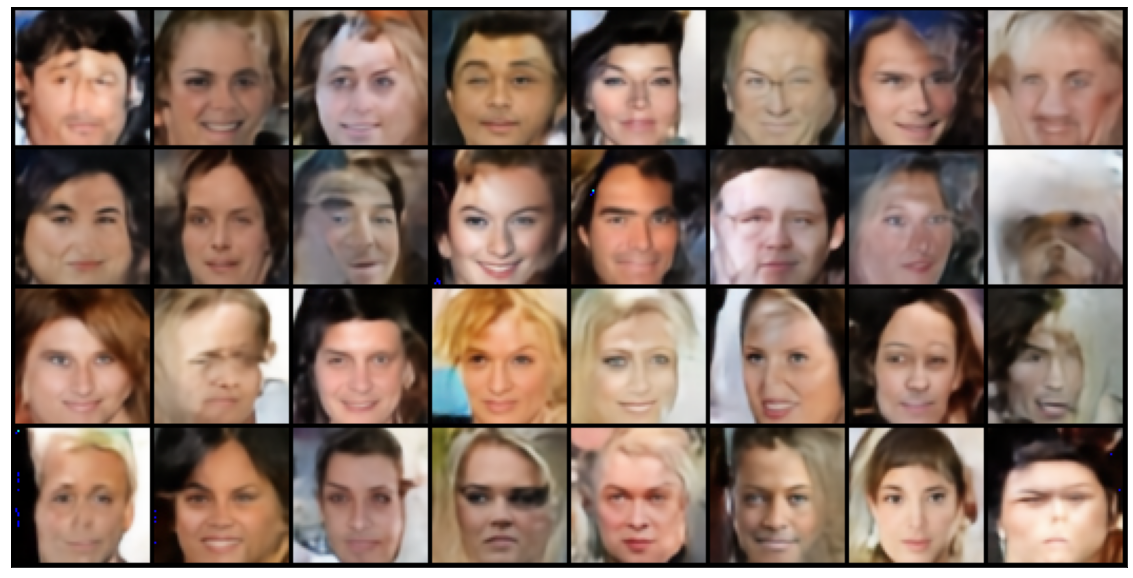

In [15]:
plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):

    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20, 20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = Ftn.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


grid = make_grid(generated_samples)
show(grid)

## Codebook Sampling

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


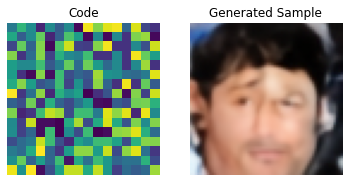

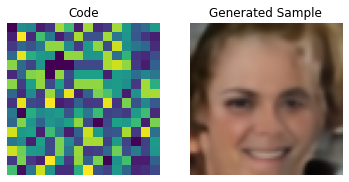

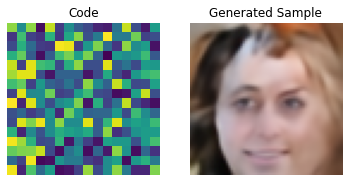

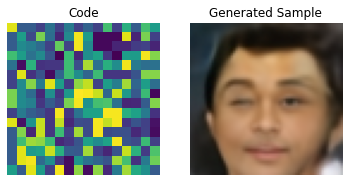

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


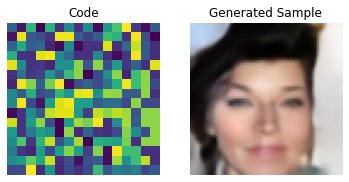

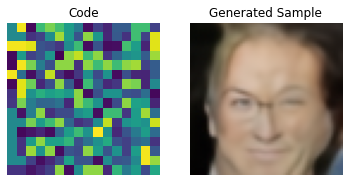

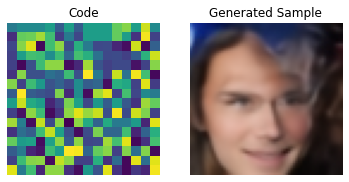

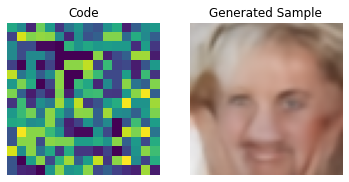

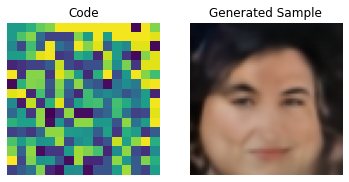

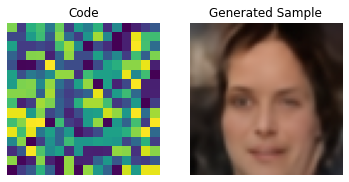

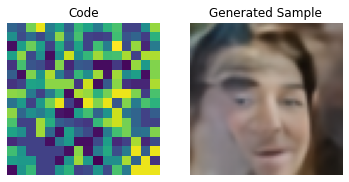

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


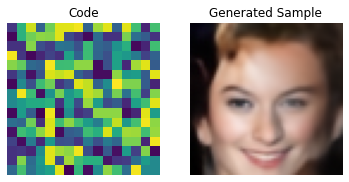

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


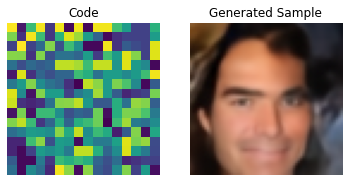

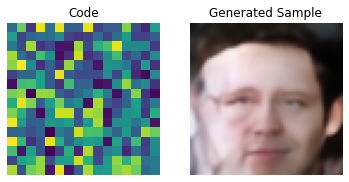

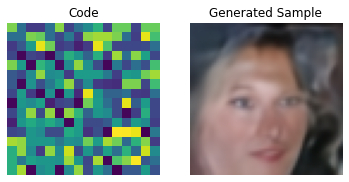

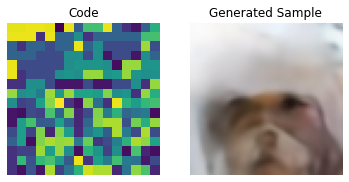

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


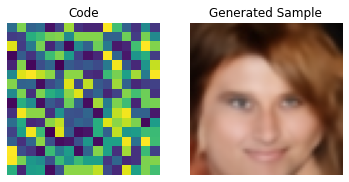

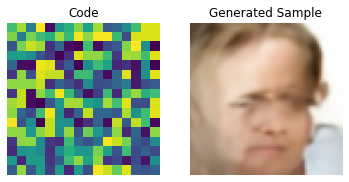

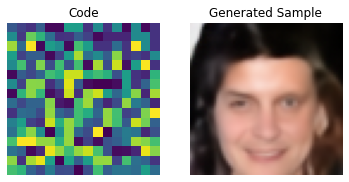

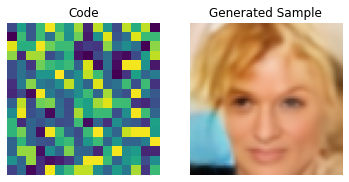

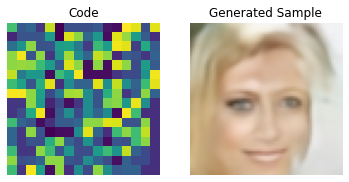

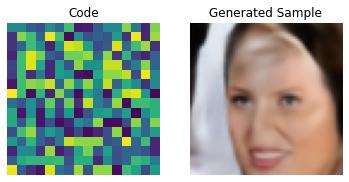

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


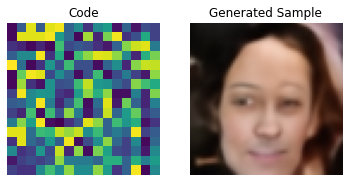

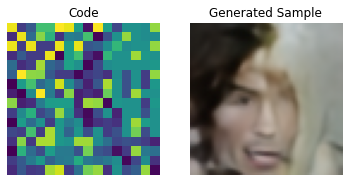

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


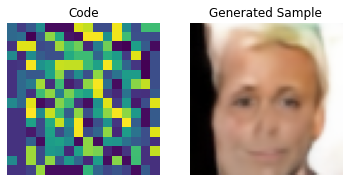

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


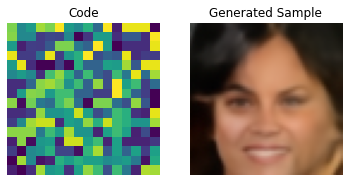

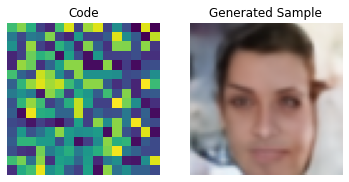

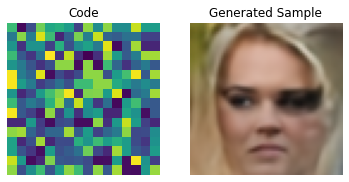

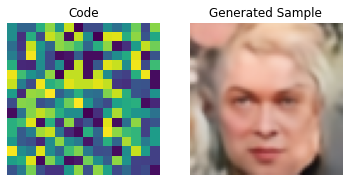

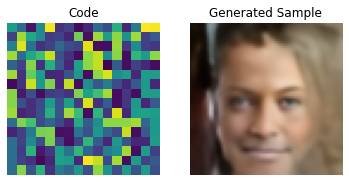

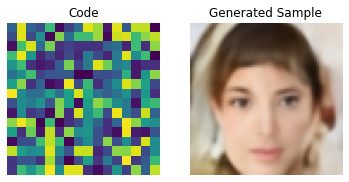

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


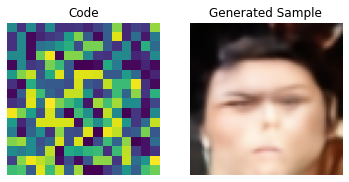

In [16]:
for i in range(N):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i].detach().cpu())
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].detach().cpu().permute(1, 2, 0).squeeze())
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()